# 线性回归
NOTE: 本示例教程依然在开发中，目前是基于2.0beta版本（由于2.0beta没有正式发版，在用最新develop版whl包下载的paddle）。

# 简要介绍
经典的线性回归模型主要用来预测一些存在着线性关系的数据集。回归模型可以理解为：存在一个点集，用一条曲线去拟合它分布的过程。如果拟合曲线是一条直线，则称为线性回归。如果是一条二次曲线，则被称为二次回归。线性回归是回归模型中最简单的一种。 
本示例简要介绍如何用飞桨开源框架，实现波士顿房价预测。其思路是，假设uci-housing数据集中的房子属性和房价之间的关系可以被属性间的线性组合描述。在模型训练阶段，让假设的预测结果和真实值之间的误差越来越小。在模型预测阶段，预测器会读取训练好的模型，对从未遇见过的房子属性进行房价预测。

# 环境设置
本示例基于飞桨开源框架2.0版本。

In [1]:
import paddle
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

paddle.__version__

'0.0.0'

# 数据集
本示例采用uci-housing数据集，这是经典线性回归的数据集。数据集共506行,每行14列。前13列用来描述房屋的各种信息，最后一列为该类房屋价格中位数。飞桨提供了读取uci_housing训练集和测试集的接口，分别为paddle.dataset.uci_housing.train()和paddle.dataset.uci_housing.test()。

前13列用来描述房屋的各种信息

![avatar](https://ai-studio-static-online.cdn.bcebos.com/c19602ce74284e3b9a50422f8dc37c0c1c79cf5cd8424994b6a6b073dcb7c057)

下面我们来浏览一下数据是什么样子的：

[-0.0405441   0.06636364 -0.32356227 -0.06916996 -0.03435197  0.05563625
 -0.03475696  0.02682186 -0.37171335 -0.21419304 -0.33569506  0.10143217
 -0.21172912]


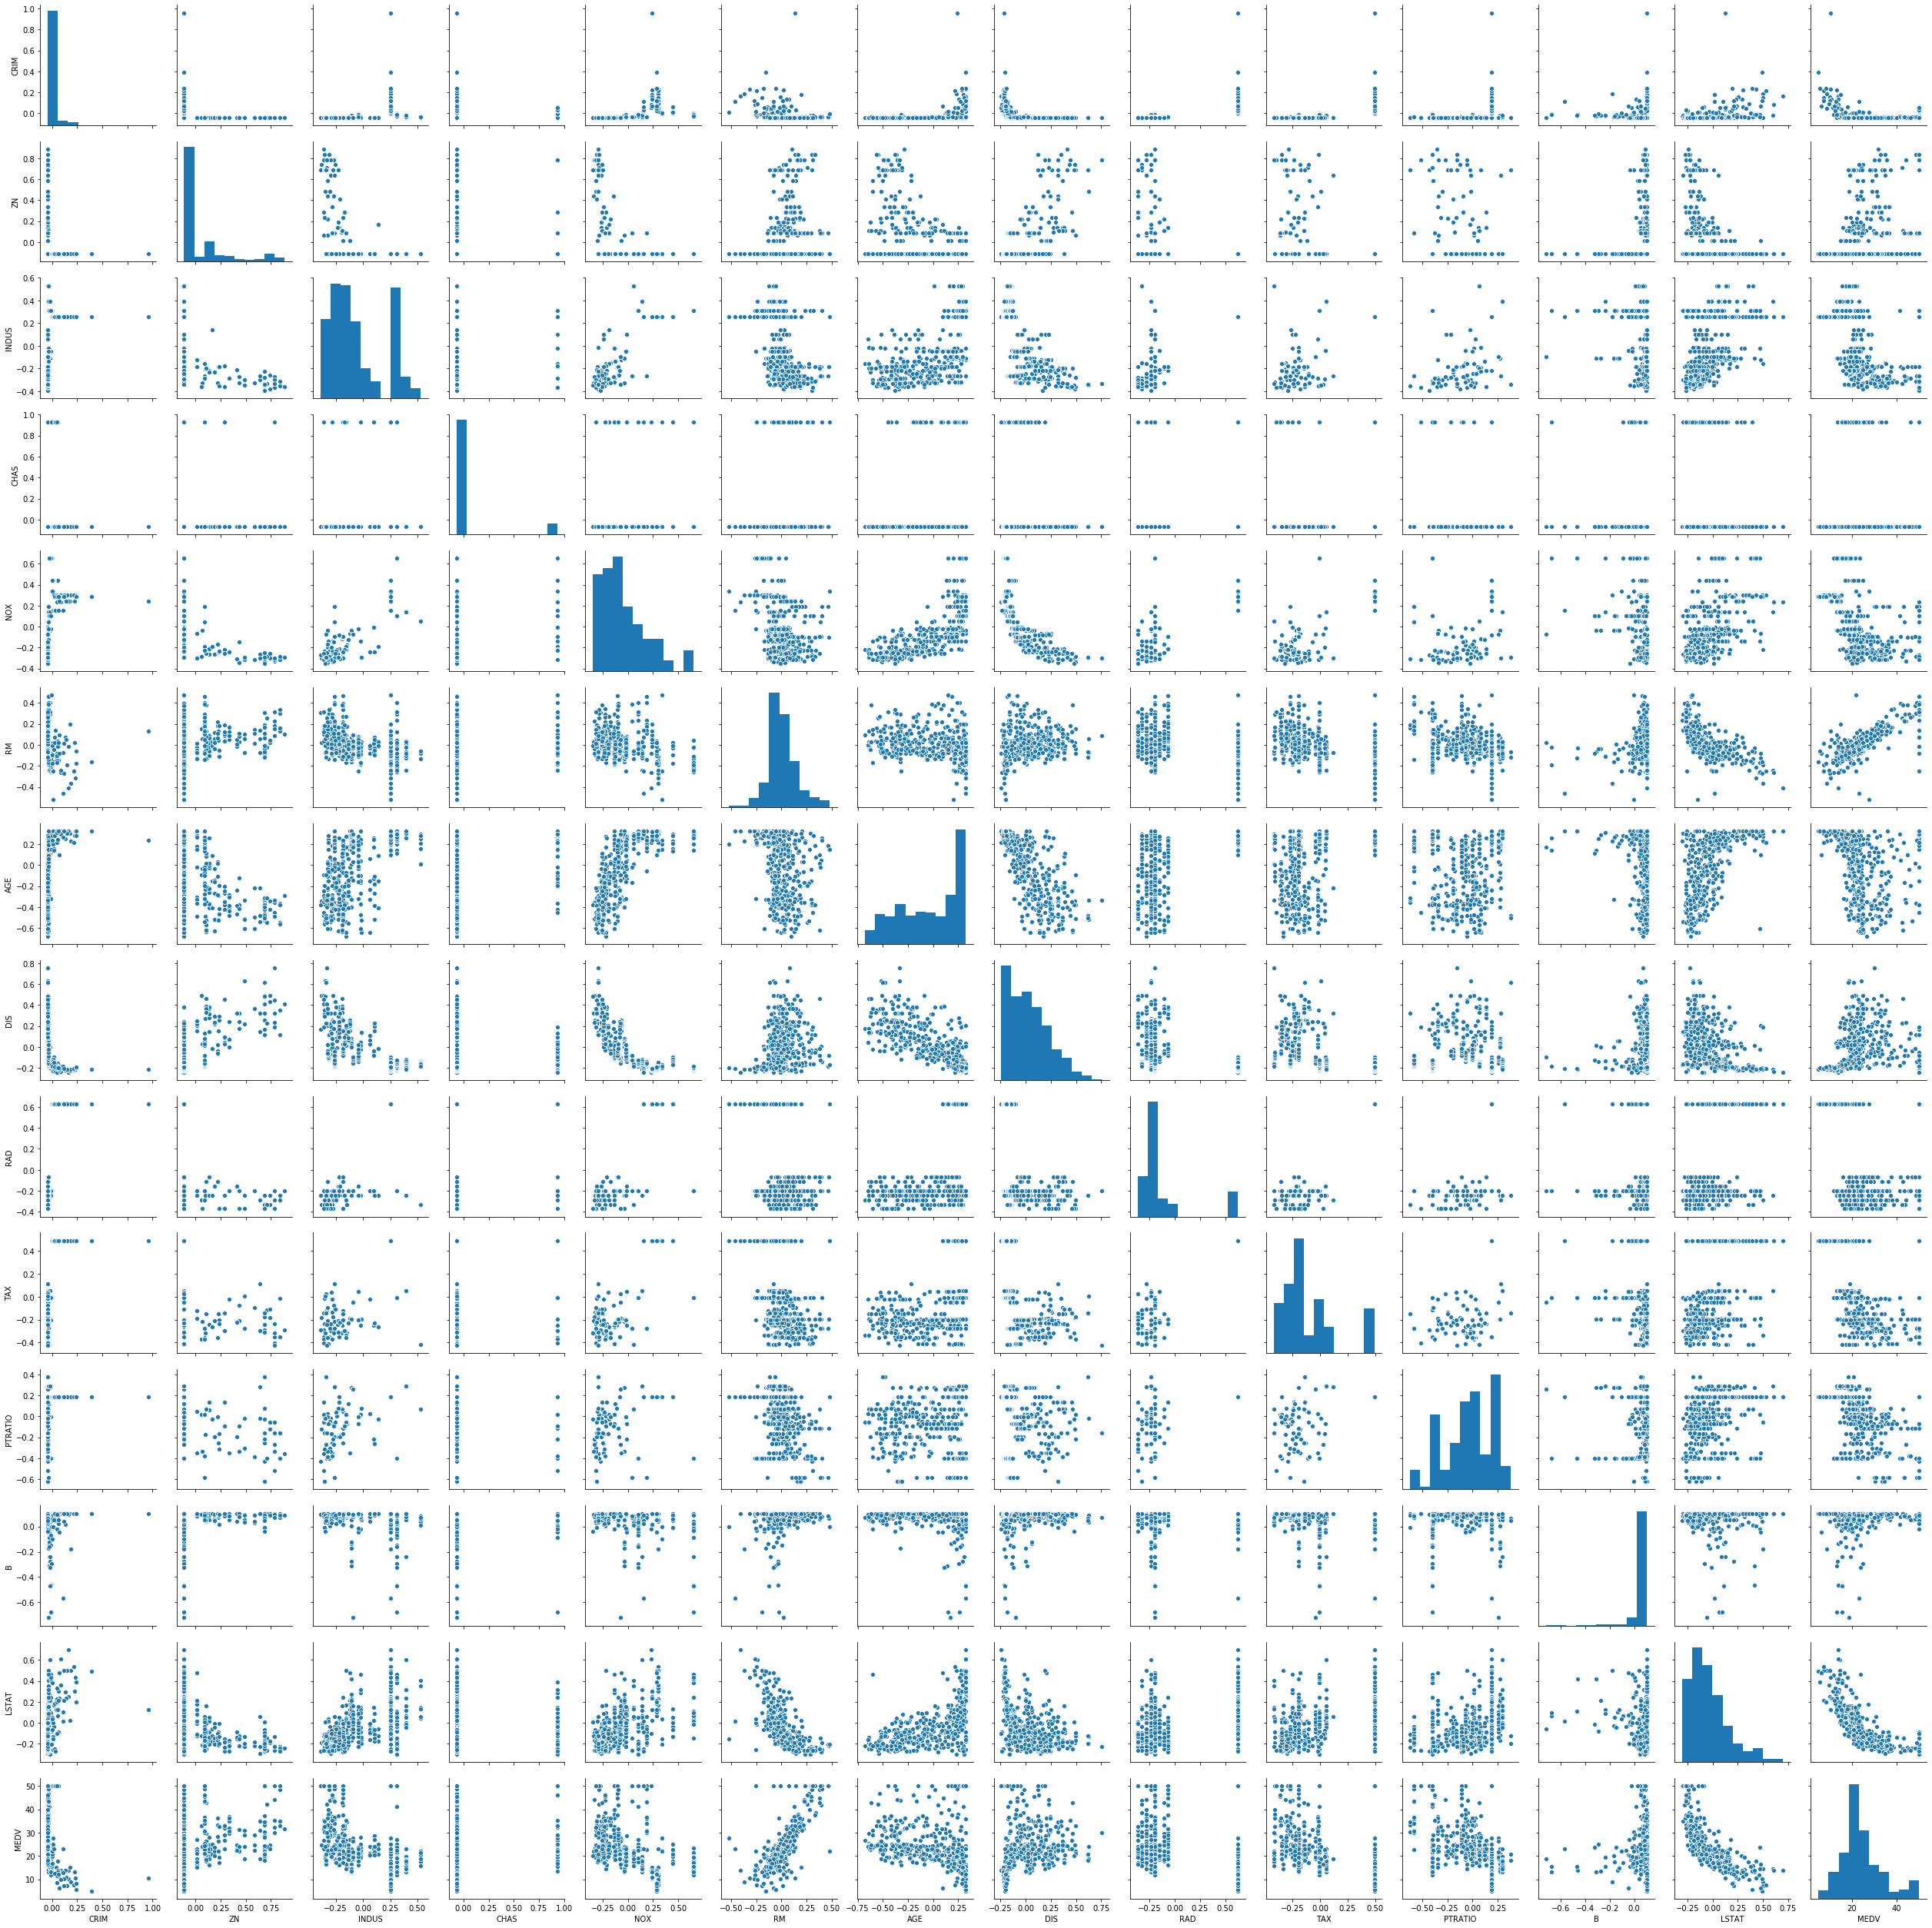

In [2]:
import matplotlib.pyplot as plt
import matplotlib

train_data=paddle.dataset.uci_housing.train()
sample_data=next(train_data())
print(sample_data[0])

# 画图看特征间的关系,主要是变量两两之间的关系（线性或非线性，有无明显较为相关关系）
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
feature_num = len(feature_names)
features_np=np.array([x[0] for x in train_data()],np.float32)
labels_np=np.array([x[1] for x in train_data()],np.float32)
data_np=np.c_[features_np,labels_np]
df=pd.DataFrame(data_np,columns=feature_names)

matplotlib.use('TkAgg')
%matplotlib inline
sns.pairplot(df.dropna())

plt.show()



上图中，对角线上是各属性的直方图，非对角线上的是两个不同属性之间的相关图。
从图中我们可以看出，RM（每栋房平均客房数）、LSTAT（低收入人群占比）、与房价成明显的相关关系、NOX（一氧化碳浓度）和DIS（与波士顿就业中心距离）成明显相关关系等。

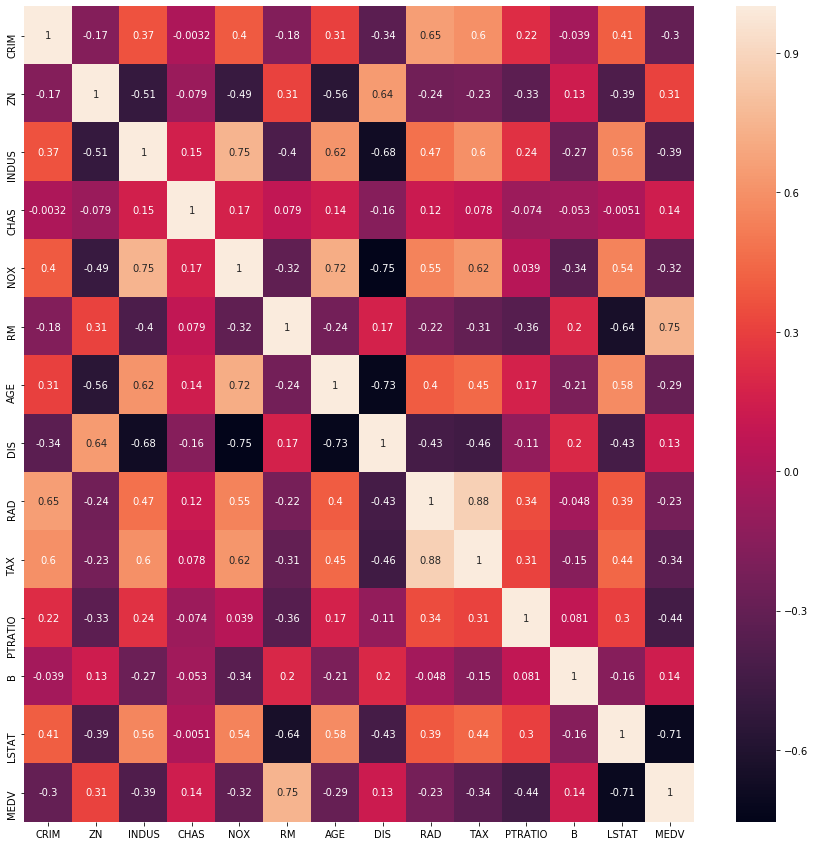

In [3]:
# 相关性分析
fig, ax = plt.subplots(figsize=(15,15)) 
ax=sns.heatmap(df.corr(), cbar=True, annot=True)
ax.set_ylim([14, 0])
plt.show()

***数据归一化处理***


下图为大家展示各属性的取值范围分布：

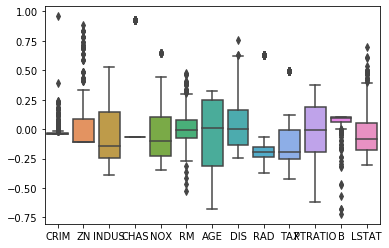

In [28]:
sns.boxplot(data=df.iloc[:,0:13])


做归一化（或 Feature scaling）至少有以下3个理由：

*   过大或过小的数值范围会导致计算时的浮点上溢或下溢。
*   不同的数值范围会导致不同属性对模型的重要性不同（至少在训练的初始阶段如此），而这个隐含的假设常常是不合理的。这会对优化的过程造成困难，使训练时间大大的加长.

*   很多的机器学习技巧/模型（例如L1，L2正则项，向量空间模型-Vector Space Model）都基于这样的假设：所有的属性取值都差不多是以0为均值且取值范围相近的。




In [29]:
features_max=[]
features_min=[]
features_avg=[]
for i in range(13):
  i_feature_max=max([data[1][0][i] for data in enumerate(train_data())])
  features_max.append(i_feature_max)
  i_feature_min=min([data[1][0][i] for data in enumerate(train_data())])
  features_min.append(i_feature_min)
  i_feature_avg=sum([data[1][0][i] for data in enumerate(train_data())])/506
  features_avg.append(i_feature_avg)


In [30]:
BATCH_SIZE=20
def feature_norm(input):
  f_size=input.shape[0]
  output_features=np.zeros((f_size,13),np.float32)
  for batch_id in range(f_size):
    for index in range(13):
      output_features[batch_id][index]=(input[batch_id][index]-features_avg[index])/(features_max[index]-features_min[index])
  return output_features 



定义绘制训练过程的损失值变化趋势的方法draw_train_process

In [6]:
global iter
iter=0
iters=[]
train_costs=[]

def draw_train_process(iters,train_costs):
    plt.title("training cost" ,fontsize=24)
    plt.xlabel("iter", fontsize=14)
    plt.ylabel("cost", fontsize=14)
    plt.plot(iters, train_costs,color='red',label='training cost')
    plt.show()
    

***数据提供器***

下面我们分别定义了用于训练和测试的数据提供器。提供器每次读入一个大小为BATCH_SIZE的数据批次。如果您希望加一些随机性，它可以同时定义一个批次大小和一个缓存大小。这样的话，每次数据提供器会从缓存中随机读取批次大小那么多的数据。

In [7]:
BATCH_SIZE=20
BUF_SIZE=500

train_reader=paddle.batch(paddle.reader.shuffle(paddle.dataset.uci_housing.train(),buf_size=BUF_SIZE),batch_size=BATCH_SIZE)

# 模型配置
线性回归就是一个从输入到输出的简单的全连接层。

对于波士顿房价数据集，假设属性和房价之间的关系可以被属性间的线性组合描述。

In [8]:
class Regressor(paddle.nn.Layer):
  def __init__(self):
    super(Regressor,self).__init__()
    self.fc=paddle.nn.Linear(13,1,None)

  def forward(self,inputs):
    pred=self.fc(inputs)
    return pred

# 模型训练
下面为大家展示模型训练的代码。
这里用到的是线性回归模型最常用的损失函数--均方误差（MSE），用来衡量模型预测的房价和真实房价的差异。
对损失函数进行优化所采用的方法是梯度下降法

In [12]:
y_preds=[]
labels_list=[]
def train(model):
  print('start training ... ')
  model.train()
  EPOCH_NUM=500
  optimizer=paddle.optimizer.SGD(learning_rate=0.001, parameters = model.parameters())
  iter=0

  for epoch_id in range(EPOCH_NUM):
    train_cost=0
    for batch_id,data in enumerate(train_reader()):
        features_np=np.array([x[0] for x in data],np.float32)
        labels_np=np.array([x[1] for x in data],np.float32)
        features=paddle.to_variable(feature_norm(features_np))
        labels=paddle.to_variable(labels_np)
        #前向计算
        y_pred=model(features)
        
        cost=paddle.nn.functional.square_error_cost(y_pred,label=labels)
        avg_cost=paddle.mean(cost)
        train_cost = [avg_cost.numpy()]
        #反向传播
        avg_cost.backward()
        #最小化loss，更新参数
        opts=optimizer.minimize(avg_cost)
        # 清除梯度
        model.clear_gradients()
        if batch_id%30==0 and epoch_id%30==0:
            print("Pass:%d,Cost:%0.5f"%(epoch_id,train_cost[0][0]))

        iter=iter+BATCH_SIZE
        iters.append(iter)
        train_costs.append(train_cost[0][0])
        
            
          
paddle.disable_static()
model = Regressor()
train(model)



start training ... 
Pass:0,Cost:531.75244
Pass:30,Cost:61.10927
Pass:60,Cost:22.68571
Pass:90,Cost:34.80560
Pass:120,Cost:78.28358
Pass:150,Cost:124.95644
Pass:180,Cost:91.88014
Pass:210,Cost:15.23689
Pass:240,Cost:34.86035
Pass:270,Cost:54.76824
Pass:300,Cost:65.88247
Pass:330,Cost:41.25426
Pass:360,Cost:64.10200
Pass:390,Cost:77.11707
Pass:420,Cost:20.80456
Pass:450,Cost:29.80167
Pass:480,Cost:41.59278


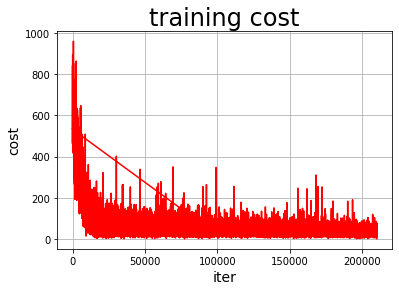

In [13]:
matplotlib.use('TkAgg')
%matplotlib inline
draw_train_process(iters,train_costs)

可以从上图看出，随着训练轮次的增加，损失在呈降低趋势。但由于每次仅基于少量样本更新参数和计算损失，所以损失下降曲线会出现震荡。

# 模型预测


In [14]:
#获取预测数据
INFER_BATCH_SIZE=100
infer_reader=paddle.batch(paddle.dataset.uci_housing.test(),batch_size=INFER_BATCH_SIZE)
infer_data = next(infer_reader())
infer_features_np = np.array([data[0] for data in infer_data]).astype("float32")
infer_labels_np= np.array([data[1] for data in infer_data]).astype("float32")

infer_features=paddle.to_variable(feature_norm(infer_features_np))
infer_labels=paddle.to_variable(infer_labels_np)
fetch_list=model(infer_features).numpy()

sum_cost=0
for i in range(INFER_BATCH_SIZE):
    infer_result=fetch_list[i][0]
    ground_truth=infer_labels.numpy()[i]
    if i%10==0:
        print("No.%d: infer result is %.2f,ground truth is %.2f" % (i, infer_result,ground_truth))
    cost=np.power(infer_result-ground_truth,2)
    sum_cost+=cost
print("平均误差为:",sum_cost/INFER_BATCH_SIZE)

No.0: infer result is 12.20,ground truth is 8.50
No.10: infer result is 5.65,ground truth is 7.00
No.20: infer result is 14.87,ground truth is 11.70
No.30: infer result is 16.60,ground truth is 11.70
No.40: infer result is 13.71,ground truth is 10.80
No.50: infer result is 16.11,ground truth is 14.90
No.60: infer result is 18.78,ground truth is 21.40
No.70: infer result is 15.53,ground truth is 13.80
No.80: infer result is 18.10,ground truth is 20.60
No.90: infer result is 21.39,ground truth is 24.50
平均误差为: [12.917107]


In [15]:
def plot_pred_ground(pred, groud):
    plt.figure()   
    plt.title("Predication v.s. Ground", fontsize=24)
    plt.xlabel("groud price(unit:$1000)", fontsize=14)
    plt.ylabel("predict price", fontsize=14)
    plt.scatter(pred, groud, alpha=0.5)  #  scatter:散点图,alpha:"透明度"
    plt.plot(groud, groud, c='red')
    plt.show()

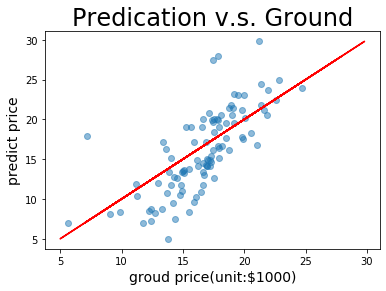

In [16]:
plot_pred_ground(fetch_list, infer_labels_np)

上图可以看出，我们训练出来的模型的预测结果与真实结果是较为接近的。